In [40]:
import pyvisa
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# rm = pyvisa.ResourceManager('@ni') # '@ni or '@py'
rm = pyvisa.ResourceManager('@ni')
print(rm)
print(rm.list_resources())

Resource Manager of Visa Library at C:\Windows\system32\visa32.dll
('GPIB0::16::INSTR', 'GPIB0::17::INSTR')


In [3]:
inst_0 = rm.open_resource('GPIB0::16::INSTR')
print("inst_0 ", inst_0.query("*IDN?"))
print("inst_0 ", inst_0.query("*TST?"))

inst_0  HEWLETT PACKARD,8703A,0,1.00

inst_0         0 



In [26]:
inst_0.write("INTE 100") # Set display intensity percent
inst_0.write("BACI 10") # Background intensity percentage

(9, <StatusCode.success: 0>)

In [26]:
'''
HYPERPARAMS
'''
inst_0.timeout = 25000 # milliseconds
f_start = "1GHZ"
f_stop = "2GHZ"
num_points = "100"
power = "0" # dB

inst_0.write("DEVTEE") # Set the device type to E/E
inst_0.write(("STAR " + f_start)) # Set start frequency
inst_0.write(("STOP " + f_stop)) # Set stop frequency
#inst_0.write(("POWE" + power)) # Ses the output power
inst_0.write(("POIN " + num_points)) # Define the number of points in the current freqency list segment
inst_0.write("LINFREQ") # Select linear frequency sweep
inst_0.write("CONT") # Set the trigger mode to continuous

inst_0.query("POIN?")

'   1.010000000000000E+02\n'

In [7]:
def string_to_freq(string):
    string = string.lower()
    if "ghz" in string:
        return float(string.replace("ghz", ""))*10**9
    elif "mhz" in string:
          return float(string.replace("mhz", ""))*10**6
    elif "khz" in string:
        return float(string.replace("khz", ""))*10**3
    elif "hz" in string:
        return float(string.replace("hz", ""))*10**0
    else:
        return float(string)*10**0

In [67]:
inst_0.write("S11") # Select parameter displayed on current active channel

(5, <StatusCode.success: 0>)

In [7]:
inst_0.write("SING") # Single sweep, then hold

(6, <StatusCode.success: 0>)

In [8]:
# inst_0.write("SMIC") # Set display to smith chart
inst_0.write("LOGM") # set display to log mag

(6, <StatusCode.success: 0>)

In [8]:
inst_0.write("OPC?")
inst_0.write("SING") # Single sweep, then hold
inst_0.write("FORM4")
print(inst_0.query_ascii_values("OUTPDATA?")) # Active channel data stored to memory trace
# print(inst_0.query("OUTPDATA?")) # Active channel data stored to memory trace

[0.0]


### Calibration: 
1. Start by selecting a calibration kit, such as 3.5mm(CALK35MM;).
2. Select a calibration type, such as S11 1-port (CALIS111;).
3. Call each class used by the calibration type, such as FORWARD: OPEN (CLASS11A;)
During a 2-port calibration, the reflection, transmission, and isolation subsequences must
be opened before the classes in the subsequence are called, and then closed at the end of
each subsequence.
4. If a class has more than one standard in it, select a standard from the menu presented
(STANA to STANG).
5. If, during a calibration, two standards are measured to satisfy one class, the class must be
closed with DONE;.
6. Declare the calibration done, such as with DONE 1-PORT CAL (SAV1;).

Copied from pg. 194 http://literature.cdn.keysight.com/litweb/pdf/08703-90058.pdf

In [52]:
inst_0.write("CALKUSED") # User defined electrical, or try CALK35MM
inst_0.write("CALIFUL2") # Select Full 2-port measurement calibration
inst_0.write("REFL") # Begin reflection part of Full 2-port cal

(6, <StatusCode.success: 0>)

Port 1

In [53]:
# Connect open at port 1
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("CLASS11A") # S11A; S11 1-port
inst_0.write("DONE") # Done with standard class during cal

(6, <StatusCode.success: 0>)

In [54]:
# Connect short at port 1
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("CLASS11B") # S11B; S11 1-port
inst_0.write("DONE") # Done with standard class during cal

(6, <StatusCode.success: 0>)

In [55]:
# Connect load at port 1
inst_0.write("CLASS11C") # S11B; S11 1-port
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("STANA") # Measure cal standard in current standard class
inst_0.write("DONE") # Done with standard class during cal

(6, <StatusCode.success: 0>)

Port 2

In [56]:
# Connect open at port 2
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("CLASS22A") # S11A; S11 1-port
inst_0.write("DONE") # Done with standard class during cal

(6, <StatusCode.success: 0>)

In [57]:
# Connect short at port 2
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("CLASS22B") # S11B; S11 1-port
inst_0.write("DONE") # Done with standard class during cal

(6, <StatusCode.success: 0>)

In [58]:
# Connect load at port 2
inst_0.write("CLASS22C") # S11B; S11 1-port
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("STANA") # Measure cal standard in current standard class
inst_0.write("DONE") # Done with standard class during cal

(6, <StatusCode.success: 0>)

In [59]:
inst_0.write("REFD") # End reflection part of Full 2-port cal
inst_0.write("TRAN") # Start transition  part of Full 2-port cal

(6, <StatusCode.success: 0>)

Port 1 <=> Port 2

In [60]:
# Connect Thru

# Forward Transmission
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("FWDT") # Select forward transmission calibration standard class - Tracking
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("FWDM") # Select forward transmission calibration standard class - Load match

# Reverse Transmission
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("REVT") # Select reverse transmission calibration standard class - Tracking
inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("REVM") # Select reverse transmission calibration standard class - Load match

inst_0.write("TRAD") # Done with transmission part of Full 2-port cal

# Skip isolation cal (?)
inst_0.write("OMII")

inst_0.write("OPC?") # Check if the following operation is complete
inst_0.write("SAV2") # save the 2 port cal



(6, <StatusCode.success: 0>)

### Measurement

In [64]:
# Trigger a single sweep
inst_0.write("OPC?")
inst_0.write("SING")
inst_0.write("FORM4")

# Collect S-parameters from the tool
inst_0.write("OPC?")
inst_0.write("S11")
# inst_0.write("SING")
s11 = inst_0.query("OUTPDATA")

inst_0.write("OPC?")
inst_0.write("S12")
# inst_0.write("SING")
s12 = inst_0.query("OUTPDATA")

inst_0.write("OPC?")
inst_0.write("S21")
# inst_0.write("SING")
s21 = inst_0.query("OUTPDATA")

inst_0.write("OPC?")
inst_0.write("S22")
# inst_0.write("SING")
s22 = inst_0.query("OUTPDATA")


In [65]:
print(s11[:50])
print(s21[:50])

   3.599548000000000E-01,  -5.041809000000000E-01

   0.289307000000000E-01,  -1.924561000000000E+00



In [66]:
# Build S-Parameters DataFrame
f = np.linspace(string_to_freq(f_start), string_to_freq(f_stop), int(num_points) + 1)

# Split entries into each real, imag pair
s11_split = s11.split("\n")
s12_split = s12.split("\n")
s21_split = s21.split("\n")
s22_split = s22.split("\n")

# Make real and imag columns for each S-parameter
s11_real = []
s11_imag = []

for i, pair in enumerate(s11_split):
    if pair == '':
        continue
    try:
        s11_real.append(pair.split(",")[0])
        s11_imag.append(pair.split(",")[1])
    except:
        print(i)

s12_real = []
s12_imag = []
        
for i, pair in enumerate(s12_split):
    if pair == '':
        continue
    try:
        s12_real.append(pair.split(",")[0])
        s12_imag.append(pair.split(",")[1])
    except:
        print(i)

s21_real = []
s21_imag = []

for i, pair in enumerate(s21_split):
    if pair == '':
        continue
    try:
        s21_real.append(pair.split(",")[0])
        s21_imag.append(pair.split(",")[1])
    except:
        print(i)
        
s22_real = []
s22_imag = []

for i, pair in enumerate(s22_split):
    if pair == '':
        continue
    try:
        s22_real.append(pair.split(",")[0])
        s22_imag.append(pair.split(",")[1])
    except:
        print(i)     

s_param_df = pd.DataFrame()
s_param_df['f'] = f
s_param_df['s11_real'] = [float(i) for i in s11_real]
s_param_df['s11_imag'] = [float(i) for i in s11_imag]
s_param_df['s12_real'] = [float(i) for i in s12_real]
s_param_df['s12_imag'] = [float(i) for i in s12_imag]
s_param_df['s21_real'] = [float(i) for i in s21_real]
s_param_df['s21_imag'] = [float(i) for i in s21_imag]
s_param_df['s22_real'] = [float(i) for i in s22_real]
s_param_df['s22_imag'] = [float(i) for i in s22_imag]

In [67]:
s_param_df.to_csv('s_params.csv')

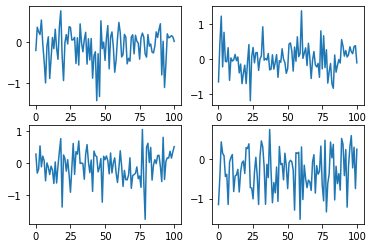

In [68]:
s11_logmag = np.log10(np.sqrt(np.add(np.power(s_param_df['s11_real'], 2), np.power(s_param_df['s11_imag'] ,2))))
s12_logmag = np.log10(np.sqrt(np.add(np.power(s_param_df['s12_real'], 2), np.power(s_param_df['s12_imag'] ,2))))
s21_logmag = np.log10(np.sqrt(np.add(np.power(s_param_df['s21_real'], 2), np.power(s_param_df['s21_imag'] ,2))))
s22_logmag = np.log10(np.sqrt(np.add(np.power(s_param_df['s22_real'], 2), np.power(s_param_df['s22_imag'] ,2))))

fig, axs = plt.subplots(2,2)
axs[0,0].plot(s11_logmag)
axs[0,1].plot(s12_logmag)
axs[1,0].plot(s21_logmag)
axs[1,1].plot(s22_logmag)

In [9]:
inst_0.write("OPC?") # Check if the following operation is complete

inst_0.write("CHAN1") # Select the active measurement channel
inst_0.write("AUXOFF") # Turn off the autxiliary channel if it is on
inst_0.write("S11") # Return loss measurement
inst_0.write("LOGM") # Log magnitude display
inst_0.write("AUTO") # Autoscale the current channel

inst_0.write("CHAN2") # Select the active measurement channel
inst_0.write("AUXOFF") # Turn off the auxiliary challen if it is on
inst_0.write("S11") # Return loss measurement
inst_0.write("PHAS") # Phase display
inst_0.write("AUTO") # Autoscale the current channel

inst_0.write("DUACON") # Dual channel display

# inst_0.write("DEVTEE") # Set the device type to E/E
inst_0.write("STAR 1GHZ") # Set start frequency
inst_0.write("STOP 2GHZ") # Set stop frequency
inst_0.write("POIN 100") # Define the number of points in the current freqency list segment
inst_0.write("LINFREQ") # Select linear frequency sweep
# inst_0.write("CONT") # Set the trigger mode to continuous

inst_0.write("CHAN1") # Select the active measurement channel
inst_0.write("AUTO") # Autoscale the current channel
inst_0.write("CHAN2") # Select the active measurement channel
inst_0.write("AUTO") # Autoscale the current channel

inst_0.write("CHAN1") # Select the active measurement channel
inst_0.write("AUXCON") # Turn on the 
inst_0.write("CHAN2") # Select the active measurement channel
inst_0.write("AUXCON") # Turn on the 

inst_0.write("S21")
inst_0.write("LOGM")
inst_0.write("AUTO")

inst_0.write("CHAN3")
inst_0.write("MEASA")
inst_0.write("LOGM")
inst_0.write("AUTO")

inst_0.write("CHAN4")
inst_0.write("MEASb")
inst_0.write("LOGM")
inst_0.write("AUTO")

inst_0.write("SPLID4")
inst_0.write("OPC?")
inst_0.write("WAIT")


(6, <StatusCode.success: 0>)

In [27]:
inst_0.write("CHAN1") # Select the active measurement channel
inst_0.write("AUXOFF") # Turn off the autxiliary channel if it is on
inst_0.write("S11") # Return loss measurement
inst_0.write("LOGM") # Log magnitude display
inst_0.write("AUTO") # Autoscale the current channel

inst_0.write("CHAN2") # Select the active measurement channel
inst_0.write("AUXOFF") # Turn off the autxiliary channel if it is on
inst_0.write("S21") # Return loss measurement
inst_0.write("LOGM") # Log magnitude display
inst_0.write("AUTO") # Autoscale the current channel

inst_0.write("DUACON") # Dual channel display


(8, <StatusCode.success: 0>)

In [54]:
pprint(out)

('   1.871643000000000E-01,   0.141678000000000E-01\n'
 '   1.405029000000000E+00,   7.104492000000000E-01\n'
 '   3.730713000000000E+00,   1.940186000000000E+00\n'
 '   0.811768000000000E-01,   8.986816000000000E-01\n'
 '   1.273499000000000E-01,   9.390869000000000E-01\n'
 '   3.052216000000000E-01,  -1.348419000000000E-01\n'
 '  -1.318359000000000E-01,  -4.366455000000000E-01\n'
 '   1.590332000000000E+00,   2.125732000000000E+00\n'
 '  -4.681396000000000E-02,   7.942505000000000E-01\n'
 '  -6.855774000000000E-02,   3.073273000000000E-01\n'
 '   3.100281000000000E-01,  -9.081421000000000E-01\n'
 '  -5.895386000000000E-01,   1.318665000000000E-01\n'
 '   1.220856000000000E-01,  -2.971039000000000E-01\n'
 '   1.120911000000000E+00,  -2.750244000000000E-01\n'
 '   0.248413000000000E-01,  -2.898560000000000E-01\n'
 '   0.115967000000000E-01,  -6.248779000000000E-01\n'
 '  -1.529114000000000E+00,   1.020569000000000E+00\n'
 '  -7.214966000000000E-01,   0.086060000000000E-01\n'
 '   1.650

In [55]:
import matplotlib.pyplot as plt

In [56]:
# out = out.split(",")

In [57]:
'''
arr_0 = []
arr_1 = []

for i, entry in enumerate(out):
    if i % 2 == 0:
        arr_0.append(entry.rstrip("\n"))
    else:
        arr_1.append(entry.rstrip("\n"))
'''     

'\narr_0 = []\narr_1 = []\n\nfor i, entry in enumerate(out):\n    if i % 2 == 0:\n        arr_0.append(entry.rstrip("\n"))\n    else:\n        arr_1.append(entry.rstrip("\n"))\n'

In [58]:
test = out 
'''
('  -1.701340000000000E-05,   7.307529000000000E-05\n'
 '   0.173375000000000E-04,  -1.228377000000000E-04\n'
 '   1.586322000000000E-05,  -1.254864000000000E-05\n'
 '  -1.112372000000000E-05,  -5.210564000000000E-05\n'
 '   7.737428000000000E-06,   1.520850000000000E-05\n'
 '   0.258535000000000E-05,   9.219348000000000E-05\n'
 '  -3.298186000000000E-05,  -2.422743000000000E-05\n'
 '  -7.267296000000000E-05,   0.438839000000000E-05\n'
 '   1.955032000000000E-05,   8.310751000000000E-05\n'
 '  -5.480275000000000E-05,   2.966449000000000E-05\n'
 '   2.342835000000000E-05,  -4.411116000000000E-05\n'
 '  -1.923963000000000E-04,  -1.020432000000000E-04\n'
 '  -7.152557000000000E-07,   1.226366000000000E-04\n'
 '  -3.158488000000000E-05,  -4.542246000000000E-05\n'
 '   7.785112000000000E-05,  -1.180992000000000E-04\n'
 '   2.440996000000000E-06,   4.601898000000000E-06\n'
 '   1.246110000000000E-05,   6.675348000000000E-05\n'
 '   6.614625000000000E-05,   3.999472000000000E-05\n'
 '   0.667572000000000E-05,  -1.033247000000000E-04\n'
 '   0.727177000000000E-05,   4.243851000000000E-05\n'
 '  -3.699213000000000E-05,   1.023561000000000E-04\n'
 '   8.071959000000000E-05,   1.447648000000000E-05\n'
 '  -1.176596000000000E-04,   5.679578000000000E-05\n'
 '   0.411570000000000E-04,   1.896396000000000E-04\n'
 '  -4.933029000000000E-05,   4.340336000000000E-05\n'
 '   7.958710000000000E-05,   4.255027000000000E-05\n'
 '   1.623109000000000E-05,  -5.269796000000000E-05\n'
 '  -1.062453000000000E-04,  -4.803389000000000E-05\n'
 '  -6.930903000000000E-05,  -2.957880000000000E-05\n'
 '  -1.037773000000000E-05,  -1.021195000000000E-05\n'
 '  -1.150966000000000E-04,  -4.314631000000000E-05\n'
 '   8.962303000000000E-05,   4.909933000000000E-05\n'
 '   3.455207000000000E-06,   8.965843000000000E-06\n'
 '  -5.979836000000000E-05,  -1.608208000000000E-05\n'
 '  -9.663403000000000E-05,  -4.962832000000000E-05\n'
 '   8.891523000000000E-05,   1.618266000000000E-05\n'
 '   1.639128000000000E-05,  -5.351380000000000E-05\n'
 '  -5.307422000000000E-05,   3.769621000000000E-05\n'
 '   6.477163000000000E-05,   2.032518000000000E-05\n'
 '  -1.265481000000000E-05,  -3.738143000000000E-05\n'
 '  -3.145077000000000E-05,  -7.005409000000000E-06\n'
 '  -3.732741000000000E-05,  -1.069345000000000E-05\n'
 '   1.750514000000000E-05,   5.440414000000000E-05\n'
 '   4.045665000000000E-05,  -1.102537000000000E-04\n'
 '  -5.267560000000000E-06,  -1.085848000000000E-04\n'
 '  -1.486465000000000E-04,  -3.709644000000000E-05\n'
 '  -4.164689000000000E-05,  -1.959503000000000E-05\n'
 '  -5.141646000000000E-05,  -3.128499000000000E-05\n'
 '  -4.043058000000000E-05,  -1.909770000000000E-05\n'
 '  -1.085252000000000E-04,  -1.247227000000000E-05\n'
 '  -1.937151000000000E-06,   1.929849000000000E-04\n'
 '   1.446344000000000E-05,  -3.090687000000000E-05\n'
 '  -6.107241000000000E-05,   0.881031000000000E-05\n'
 '   1.908094000000000E-05,   9.819120000000000E-05\n'
 '  -1.242757000000000E-04,   0.163466000000000E-04\n'
 '   6.828085000000000E-05,   6.928668000000000E-05\n'
 '   4.385784000000000E-05,  -6.166101000000000E-05\n'
 '   0.662543000000000E-05,   2.552010000000000E-05\n'
 '   6.411225000000000E-05,   1.485273000000000E-05\n'
 '   0.307709000000000E-05,  -5.821512000000000E-05\n'
 '  -1.163706000000000E-04,  -4.507601000000000E-06\n'
 '   4.171394000000000E-05,  -3.027171000000000E-05\n'
 '   1.380295000000000E-04,   0.267103000000000E-04\n'
 '  -1.220778000000000E-05,   5.109981000000000E-05\n'
 '  -1.077876000000000E-04,   2.975017000000000E-05\n'
 '   6.961823000000000E-05,   7.616357000000000E-05\n'
 '  -1.006275000000000E-04,  -5.582720000000000E-05\n'
 '  -8.672476000000000E-05,   2.619624000000000E-05\n'
 '   1.876876000000000E-04,   0.474080000000000E-04\n'
 '  -1.034886000000000E-04,  -1.032352000000000E-04\n'
 '   3.303215000000000E-05,  -2.477318000000000E-07\n'
 '  -7.748232000000000E-05,   0.340119000000000E-05\n'
 '   2.877042000000000E-05,  -2.737343000000000E-05\n'
 '  -3.908947000000000E-05,   9.285287000000000E-05\n'
 '  -1.372211000000000E-05,  -3.215485000000000E-05\n'
 '   0.450611000000000E-04,  -1.350492000000000E-04\n'
 '  -7.292628000000000E-05,   0.100210000000000E-05\n'
 '  -3.965572000000000E-05,  -3.992394000000000E-05\n'
 '   3.217161000000000E-05,   4.159287000000000E-05\n'
 '  -7.957593000000000E-05,  -5.156547000000000E-05\n'
 '   1.702271000000000E-05,   3.072619000000000E-05\n'
 '  -1.901202000000000E-05,  -2.348796000000000E-05\n'
 '  -3.645011000000000E-05,   2.209097000000000E-05\n'
 '   4.968792000000000E-05,  -5.969778000000000E-05\n'
 '   8.680300000000000E-05,   4.684553000000000E-05\n'
 '  -8.097291000000000E-05,   2.294034000000000E-05\n'
 '  -6.584078000000000E-05,  -7.116795000000000E-05\n'
 '  -9.775162000000000E-06,   1.064241000000000E-04\n'
 '   0.154451000000000E-04,  -1.689419000000000E-04\n'
 '  -5.368143000000000E-05,   1.498535000000000E-04\n'
 '  -1.260415000000000E-04,   0.247359000000000E-04\n'
 '   6.653368000000000E-05,  -1.166985000000000E-04\n'
 '   8.805096000000000E-05,   8.039550000000000E-05\n'
 '   5.000830000000000E-05,   3.892556000000000E-05\n'
 '   2.655759000000000E-05,   2.993271000000000E-05\n'
 '  -5.264953000000000E-05,  -1.734123000000000E-05\n'
 '  -3.964454000000000E-05,   1.126528000000000E-04\n'
 '   5.229563000000000E-05,  -4.573166000000000E-05\n'
 '   0.351295000000000E-05,   6.152318000000000E-05\n'
 '   3.487058000000000E-05,   0.725500000000000E-05\n'
 '   7.726625000000000E-05,  -5.716085000000000E-05\n'
 '   1.079440000000000E-04,  -3.601611000000000E-05\n'
 '  -1.494586000000000E-05,   1.300499000000000E-04\n'
 '  -8.986145000000000E-05,  -1.857504000000000E-04\n'
 '   1.297668000000000E-04,  -1.022443000000000E-04\n'
 '   0.500306000000000E-05,  -3.569573000000000E-05\n'
 '   7.942319000000000E-05,   6.188080000000000E-05\n'
 '   2.450682000000000E-05,   0.243261000000000E-05\n'
 '  -7.081032000000000E-05,   5.535036000000000E-05\n'
 '   1.422763000000000E-04,  -1.927912000000000E-04\n'
 '   0.004694000000000E-04,   1.728013000000000E-04\n'
 '  -5.936623000000000E-05,  -1.944602000000000E-06\n'
 '  -9.353459000000000E-05,  -4.430115000000000E-05\n'
 '  -4.380941000000000E-05,   1.953095000000000E-04\n'
 '   1.113266000000000E-04,  -6.356835000000000E-05\n'
 '  -2.202392000000000E-05,   2.415776000000000E-04\n'
 '  -1.062974000000000E-04,  -1.376793000000000E-04\n'
 '   2.230406000000000E-04,   2.384037000000000E-04\n'
 '  -3.124326000000000E-04,  -6.209314000000000E-05\n'
 '   2.211779000000000E-04,  -2.634525000000000E-05\n'
 '  -2.330691000000000E-04,   0.061840000000000E-04\n'
 '   2.272725000000000E-04,  -4.693866000000000E-06\n'
 '  -2.279431000000000E-04,   3.080964000000000E-04\n'
 '  -1.148582000000000E-04,  -3.071576000000000E-04\n'
 '   1.111180000000000E-04,   2.746284000000000E-04\n'
 '  -2.772063000000000E-04,  -2.230704000000000E-05\n'
 '   2.386123000000000E-04,   1.592487000000000E-04\n'
 '  -1.597777000000000E-04,  -5.194545000000000E-05\n'
 '   1.451820000000000E-04,   1.038462000000000E-04\n'
 '  -2.104342000000000E-04,  -1.181364000000000E-04\n'
 '   2.439171000000000E-04,  -1.024306000000000E-04\n'
 '  -3.638864000000000E-04,   1.701266000000000E-04\n'
 '   4.095137000000000E-04,  -2.522767000000000E-04\n'
 '  -2.202392000000000E-04,   5.129874000000000E-04\n'
 '  -3.874302000000000E-06,  -7.552207000000000E-04\n'
 '   3.696680000000000E-04,   4.738867000000000E-04\n'
 '  -5.128384000000000E-04,  -4.203320000000000E-04\n'
 '   7.295310000000000E-04,   0.978410000000000E-04\n'
 '  -6.171465000000000E-04,   3.022552000000000E-04\n'
 '   2.183020000000000E-04,  -4.063249000000000E-04\n'
 '  -1.936108000000000E-04,   3.089458000000000E-04\n'
 '   3.198087000000000E-04,  -5.807579000000000E-04\n'
 '   0.987649000000000E-04,   7.005036000000000E-04\n'
 '  -5.176663000000000E-04,  -6.582141000000000E-04\n'
 '   6.321073000000000E-04,   0.408590000000000E-04\n'
 '  -5.118549000000000E-04,  -2.002716000000000E-05\n'
 '   3.831834000000000E-04,  -7.076561000000000E-05\n'
 '  -2.758056000000000E-04,   1.806468000000000E-04\n'
 '   3.504902000000000E-04,  -1.732260000000000E-04\n'
 '  -2.594441000000000E-04,   3.827512000000000E-04\n'
 '  -3.859401000000000E-05,  -4.336238000000000E-04\n'
 '   2.471507000000000E-04,   3.667623000000000E-04\n'
 '  -1.123473000000000E-04,  -1.107231000000000E-04\n'
 '  -2.123266000000000E-04,  -8.223951000000000E-05\n'
 '   3.057122000000000E-04,  -4.716814000000000E-04\n'
 '  -3.963709000000000E-06,   7.322729000000000E-04\n'
 '  -5.365014000000000E-04,  -4.179180000000000E-04\n'
 '   5.740523000000000E-04,   4.983246000000000E-04\n'
 '  -8.829832000000000E-04,  -4.288554000000000E-04\n'
 '   1.431167000000000E-03,   1.092553000000000E-04\n'
 '  -1.904249000000000E-03,   1.149416000000000E-03\n'
 '   0.352383000000000E-03,  -2.550721000000000E-03\n'
 '   0.547886000000000E-03,   2.419710000000000E-03\n'
 '  -2.321362000000000E-03,  -1.577258000000000E-03\n'
 '   2.583504000000000E-03,   0.468731000000000E-03\n'
 '  -1.762509000000000E-03,   1.208067000000000E-03\n'
 '   1.957178000000000E-03,  -1.478195000000000E-03\n'
 '  -1.239777000000000E-05,   3.380775000000000E-03\n'
 '  -1.735091000000000E-03,  -2.442837000000000E-03\n'
 '   2.757430000000000E-03,   0.993371000000000E-03\n'
 '  -1.764297000000000E-03,   7.572174000000000E-04\n'
 '   8.796453000000000E-04,  -1.176417000000000E-03\n'
 '  -4.315376000000000E-05,   1.293659000000000E-03\n'
 '  -7.778704000000000E-04,  -5.790293000000000E-04\n'
 '   6.145835000000000E-04,   0.115037000000000E-04\n'
 '  -1.956075000000000E-04,   1.580864000000000E-04\n'
 '   2.832385000000000E-06,  -1.904438000000000E-06\n'
 '  -6.312132000000000E-05,   2.537295000000000E-05\n'
 '   5.431101000000000E-05,  -4.405901000000000E-05\n'
 '   3.544241000000000E-05,  -3.265217000000000E-05\n'
 '  -2.077781000000000E-05,  -4.390441000000000E-05\n'
 '  -7.233769000000000E-05,  -1.079291000000000E-04\n'
 '   0.195391000000000E-05,  -3.406778000000000E-05\n'
 '   5.749241000000000E-05,   3.601983000000000E-05\n'
 '   9.416789000000000E-05,  -7.806346000000000E-05\n'
 '  -9.875745000000000E-06,   5.623698000000000E-05\n'
 '   4.617311000000000E-05,  -6.156043000000000E-06\n'
 '  -4.307553000000000E-05,  -7.074699000000000E-05\n'
 '  -6.578863000000000E-05,  -4.663318000000000E-05\n'
 '   3.216416000000000E-05,   5.152076000000000E-05\n'
 '   1.143524000000000E-05,  -7.841270000000000E-06\n'
 '  -1.200661000000000E-04,   4.828721000000000E-05\n'
 '  -2.051890000000000E-05,  -1.200140000000000E-04\n'
 '   3.638119000000000E-05,   6.699190000000000E-05\n'
 '  -1.438856000000000E-04,  -6.506592000000000E-05\n'
 '   9.574741000000000E-05,  -6.951392000000000E-06\n'
 '  -3.693998000000000E-05,   1.177788000000000E-04\n'
 '   1.457334000000000E-05,  -2.673455000000000E-05\n'
 '   0.919327000000000E-04,  -1.489595000000000E-04\n'
 '  -1.423433000000000E-04,  -3.421307000000000E-05\n'
 '   4.230812000000000E-05,   1.264736000000000E-05\n')
'''

"\n('  -1.701340000000000E-05,   7.307529000000000E-05\n'\n '   0.173375000000000E-04,  -1.228377000000000E-04\n'\n '   1.586322000000000E-05,  -1.254864000000000E-05\n'\n '  -1.112372000000000E-05,  -5.210564000000000E-05\n'\n '   7.737428000000000E-06,   1.520850000000000E-05\n'\n '   0.258535000000000E-05,   9.219348000000000E-05\n'\n '  -3.298186000000000E-05,  -2.422743000000000E-05\n'\n '  -7.267296000000000E-05,   0.438839000000000E-05\n'\n '   1.955032000000000E-05,   8.310751000000000E-05\n'\n '  -5.480275000000000E-05,   2.966449000000000E-05\n'\n '   2.342835000000000E-05,  -4.411116000000000E-05\n'\n '  -1.923963000000000E-04,  -1.020432000000000E-04\n'\n '  -7.152557000000000E-07,   1.226366000000000E-04\n'\n '  -3.158488000000000E-05,  -4.542246000000000E-05\n'\n '   7.785112000000000E-05,  -1.180992000000000E-04\n'\n '   2.440996000000000E-06,   4.601898000000000E-06\n'\n '   1.246110000000000E-05,   6.675348000000000E-05\n'\n '   6.614625000000000E-05,   3.9994720000000

In [59]:
type(test)

str

In [60]:
test = test.split("\n")
test

['   1.871643000000000E-01,   0.141678000000000E-01',
 '   1.405029000000000E+00,   7.104492000000000E-01',
 '   3.730713000000000E+00,   1.940186000000000E+00',
 '   0.811768000000000E-01,   8.986816000000000E-01',
 '   1.273499000000000E-01,   9.390869000000000E-01',
 '   3.052216000000000E-01,  -1.348419000000000E-01',
 '  -1.318359000000000E-01,  -4.366455000000000E-01',
 '   1.590332000000000E+00,   2.125732000000000E+00',
 '  -4.681396000000000E-02,   7.942505000000000E-01',
 '  -6.855774000000000E-02,   3.073273000000000E-01',
 '   3.100281000000000E-01,  -9.081421000000000E-01',
 '  -5.895386000000000E-01,   1.318665000000000E-01',
 '   1.220856000000000E-01,  -2.971039000000000E-01',
 '   1.120911000000000E+00,  -2.750244000000000E-01',
 '   0.248413000000000E-01,  -2.898560000000000E-01',
 '   0.115967000000000E-01,  -6.248779000000000E-01',
 '  -1.529114000000000E+00,   1.020569000000000E+00',
 '  -7.214966000000000E-01,   0.086060000000000E-01',
 '   1.650391000000000E-01, 

In [61]:
arr_0 = []
arr_1 = []

for i, pair in enumerate(test):
    if pair == '':
        continue
    try:
        arr_0.append(pair.split(",")[0])
        arr_1.append(pair.split(",")[1])
    except:
        print(i)

In [62]:
arr_0

['   1.871643000000000E-01',
 '   1.405029000000000E+00',
 '   3.730713000000000E+00',
 '   0.811768000000000E-01',
 '   1.273499000000000E-01',
 '   3.052216000000000E-01',
 '  -1.318359000000000E-01',
 '   1.590332000000000E+00',
 '  -4.681396000000000E-02',
 '  -6.855774000000000E-02',
 '   3.100281000000000E-01',
 '  -5.895386000000000E-01',
 '   1.220856000000000E-01',
 '   1.120911000000000E+00',
 '   0.248413000000000E-01',
 '   0.115967000000000E-01',
 '  -1.529114000000000E+00',
 '  -7.214966000000000E-01',
 '   1.650391000000000E-01',
 '   3.847656000000000E-01',
 '   1.325531000000000E-01',
 '  -4.871826000000000E-01',
 '   2.918701000000000E-01',
 '   2.277344000000000E+00',
 '  -3.134155000000000E-01',
 '   1.166000000000000E-01',
 '   9.712830000000000E-01',
 '  -7.268677000000000E-01',
 '  -1.017761000000000E-02',
 '   4.302368000000000E-01',
 '   2.386627000000000E-01',
 '  -1.816711000000000E-01',
 '   0.334625000000000E-01',
 '  -5.621033000000000E-01',
 '   0.7159420

In [63]:
arr_0 = [float(i) for i in arr_0]
arr_1 = [float(i) for i in arr_1]

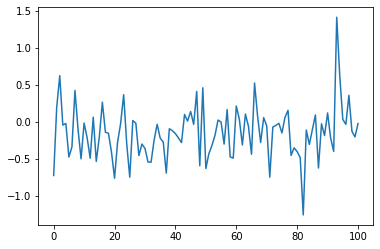

In [64]:
logmag = np.log10(np.sqrt(np.add(np.power(arr_0, 2), np.power(arr_1 ,2))))
plt.plot(logmag)